# Przetwarzanie języka naturalnego, PWR 2024
## Analiza sentymentu recenzji filmów
Autorzy:
- Dominik Ćwikowski 248914
- Konrad Maciejczyk 276927

Repozytorium:  
- https://github.com/F3mte/NLP-projekt

Zbiór danych:  
- https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews

In [5]:
# import basic labriaries
import numpy as np 
import pandas as pd 
import os
import pickle
# disable warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# list files from input directory
print(os.listdir("./input"))

['sampleSubmission.csv', 'test.tsv', 'train.tsv']


In [6]:
# NLTK (The Natural Language Toolkit) is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
# TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [7]:
# We all, of course, know what Keras is
from keras.utils import to_categorical, pad_sequences
import random
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN 
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.config import list_physical_devices
# set random seed for the session and also for tensorflow that runs in background for keras
set_seed(42)
random.seed(42)
# check available GPUs
print(f"Num GPUs Available: {len(list_physical_devices('GPU'))}")

Num GPUs Available: 0


In [24]:
import matplotlib.pyplot as plt

In [8]:
# read and check training data
train= pd.read_csv("./input/train.tsv", sep="\t")
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
# read and check test data
test = pd.read_csv("./input/test.tsv", sep="\t")
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [10]:
# function for cleaning sentenes from data set
def clean_sentences(df):
    reviews = []
    df.dropna(axis=0, inplace=True)                            # remove empty values
    for sent in tqdm(df['Phrase']):
        review_text = BeautifulSoup(sent).get_text()           # remove html content
        review_text = re.sub("[^a-zA-Z]"," ", review_text)     # remove non-alphabetic characters
        words = word_tokenize(review_text.lower())             # tokenize the sentences
        lemma_words = [lemmatizer.lemmatize(i) for i in words] # lemmatize each word
        reviews.append(lemma_words)                            # add to list that will be returned
    return(reviews)

In [11]:
# install necessary resources
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(f"Length of training sequence: {len(train_sentences)}")
print(f"Length of testing sequence:  {len(test_sentences)}")

  1%|█                                                                         | 2247/156060 [00:01<01:02, 2464.98it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19312\2429433190.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(sent).get_text()           # remove html content
100%|██████████████████████████████████████████████████████████████████████████| 66291/66291 [00:09<00:00, 6637.88it/s]

Length of training sequence: 156060
Length of testing sequence:  66291


In [13]:
# collect the dependent values and convert to one-hot encoded output using to_categorical
y_target = to_categorical(train.Sentiment.values)
num_classes = y_target.shape[1]
y_target

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [14]:
# split into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.1, stratify=y_target)

In [15]:
# create set of unique words and find the longest sentence length to determine the padding needed for other sentences to match it
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)
    if(len_max<len(sent)):
        len_max = len(sent)

print(f"Number of unique words:         {len(list(unique_words))}")
print(f"Length of the longest sentence: {len_max}")

100%|██████████████████████████████████████████████████████████████████████| 140454/140454 [00:00<00:00, 820673.85it/s]

Number of unique words:         13745
Length of the longest sentence: 48


In [16]:
# create tokenizer
#X_train = map(str, X_train)
#X_val = map(str, X_val)
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

In [17]:
# pass subsets through tokenizer
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [18]:
# padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
# Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = pad_sequences(X_train, maxlen=len_max)
X_val = pad_sequences(X_val, maxlen=len_max)
X_test = pad_sequences(X_test, maxlen=len_max)

print(X_train.shape, X_val.shape, X_test.shape)

(140454, 48) (15606, 48) (66291, 48)


In [19]:
# function that create model
def create_model(architecture, optimizer, lr):
    '''
    architecture - choose among 4 possible model architectures:
                   'LSTM-GRU', 'LSTM', 'GRU', 'RNN'
    optimizer - choose among 5 possible optimizers:
                'Adam', 'RMSprop', 'SGD', 'Momentum', 'Adadelta'
    lr - choose learning rate for optimizer
    '''
    model = Sequential()
    model.add(Embedding(len(list(unique_words)), 50, input_length=len_max)),
    # choose model qrchitecture
    if architecture == 'LSTM-GRU':
        model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
        model.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    elif architecture == 'LSTM':
        model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
        model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    elif architecture == 'GRU':
        model.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
        model.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    elif architecture == 'RNN':
        model.add(SimpleRNN(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
        model.add(SimpleRNN(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    # add last dense layers
    model.add(Dense(len(list(unique_words)), activation='relu')),
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model and print summary
    if optimizer == 'Adam':
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])
    elif optimizer == 'SGD':
        model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=lr), metrics=['accuracy'])
    elif optimizer == 'Momentum':
        model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=lr, momentum=0.9), metrics=['accuracy'])
    elif optimizer == 'Adadelta':
        model.compile(loss='categorical_crossentropy', optimizer=Adadelta(learning_rate=lr), metrics=['accuracy'])
    elif optimizer == 'Adagrad':
        model.compile(loss='categorical_crossentropy', optimizer=Adagrad(learning_rate=lr), metrics=['accuracy'])
    # print summary and return model
    model.summary()
    return model

In [20]:
# function for plotting accuraccy
def plot_accuracies(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and testing accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['Training', 'testing'])
    plt.show()
    print("")

    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and testing loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['Training', 'testing'])
    plt.show()

# Hyperparameter Tuning
## Learning rate

In [21]:
# create inital model to perform learning rate tuning
# Adagrad is used for now, later will be discarded for other optimizer
model_name = 'learning_rate_0dot01'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=0.01)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=16,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 50)            687250    
                                                                 
 lstm (LSTM)                 (None, 48, 64)            29440     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 13745)             893425    
                                                                 
 dropout (Dropout)           (None, 13745)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
Non-

NameError: name 'plt' is not defined

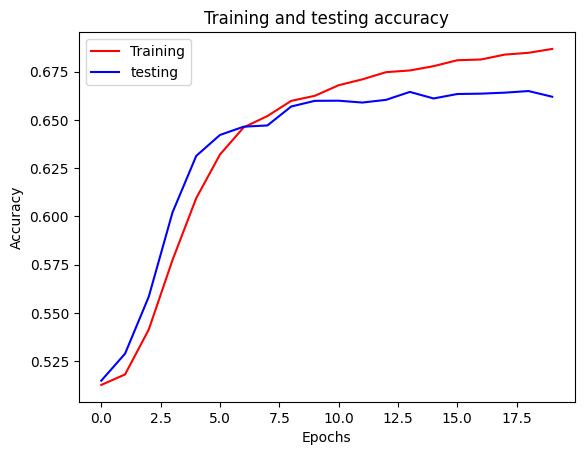

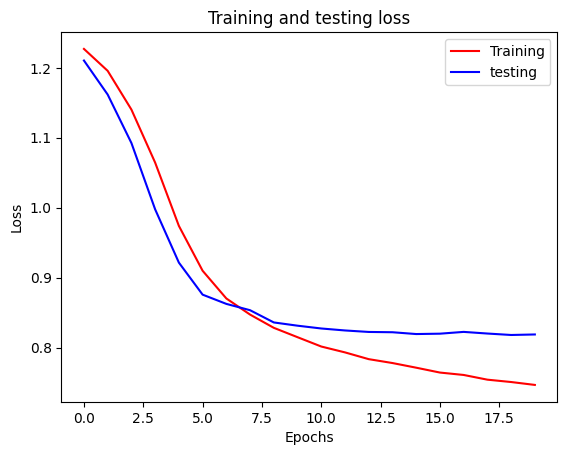

In [25]:
plot_accuracies(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_1 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 13745)             893425    
                                                                 
 dropout_1 (Dropout)         (None, 13745)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

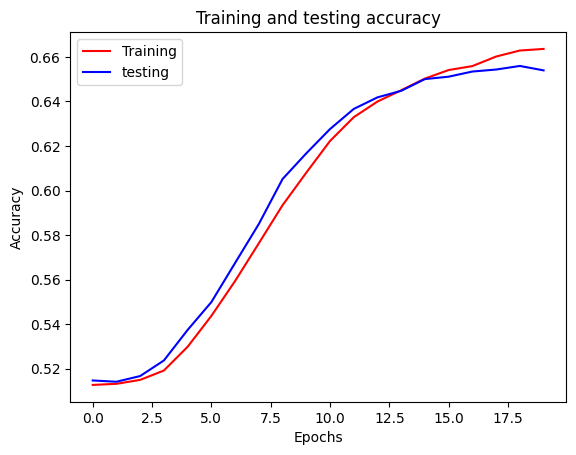

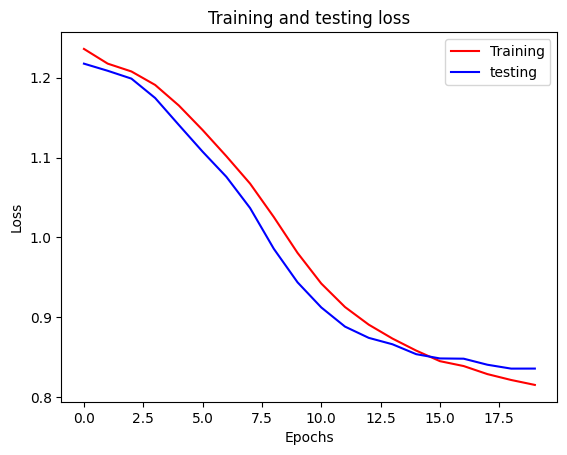

In [26]:
model_name = 'learning_rate_0dot005'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=0.005)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=16,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 13745)             893425    
                                                                 
 dropout_2 (Dropout)         (None, 13745)             0         
                                                                 
 dense_5 (Dense)             (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

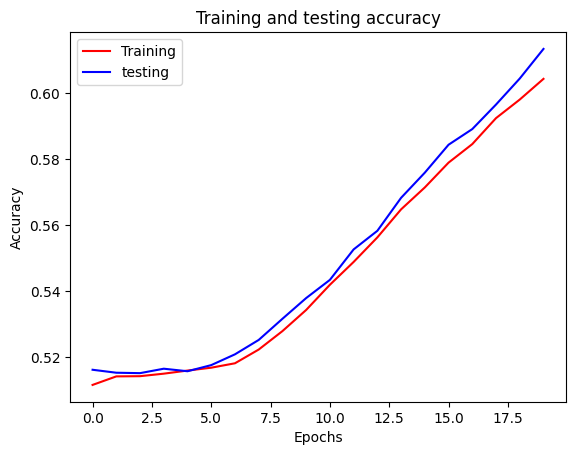

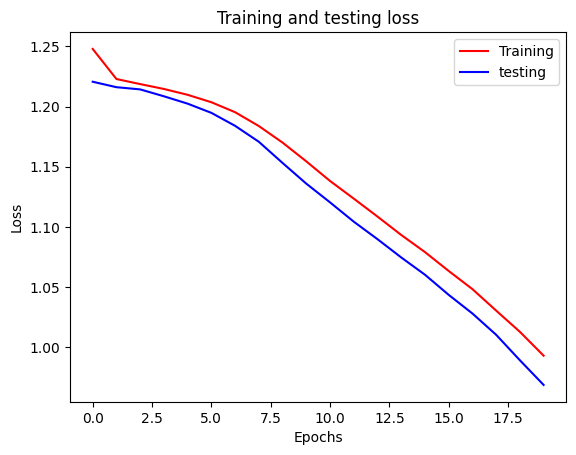

In [27]:
model_name = 'learning_rate_0dot0025'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=0.0025)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=16,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_3 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 13745)             893425    
                                                                 
 dropout_3 (Dropout)         (None, 13745)             0         
                                                                 
 dense_7 (Dense)             (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

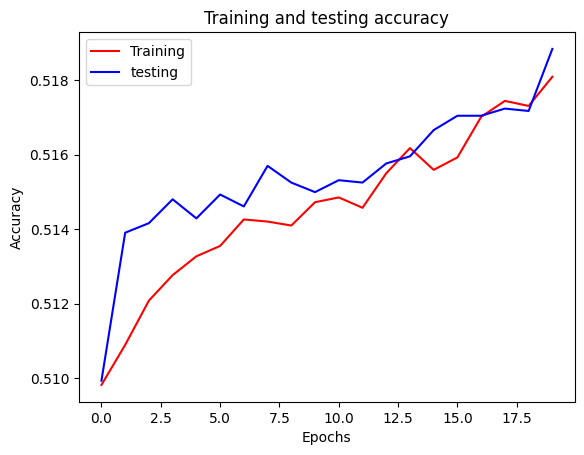

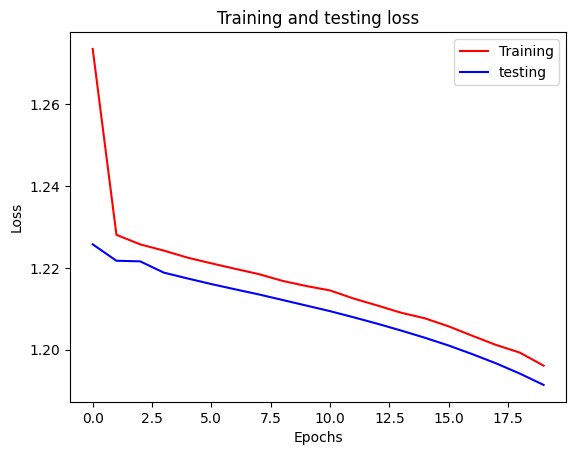

In [28]:
model_name = 'learning_rate_0dot001'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=0.001)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=16,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

In [29]:
# Use best learning rate value
best_lr = 0.01

# Hyperparameter Tuning
## Batch Size

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_4 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dense_8 (Dense)             (None, 13745)             893425    
                                                                 
 dropout_4 (Dropout)         (None, 13745)             0         
                                                                 
 dense_9 (Dense)             (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

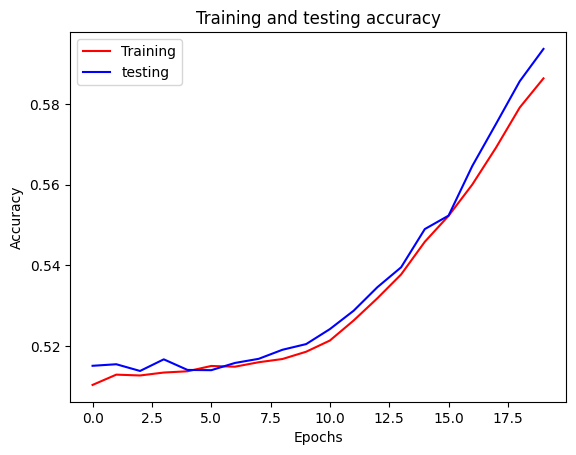

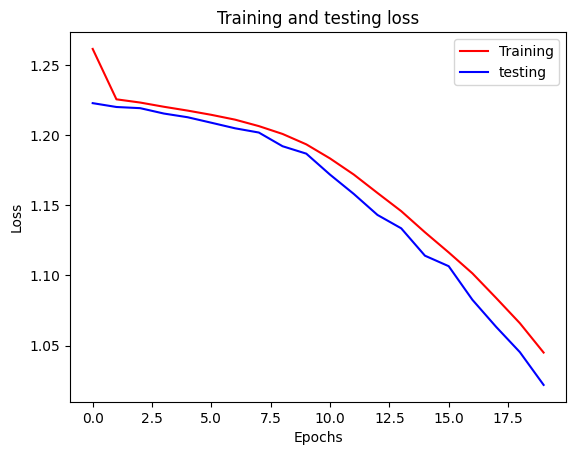

In [30]:
model_name = 'batch_size_128'
in_batch_size = 128
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=in_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_5 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_10 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_5 (Dropout)         (None, 13745)             0         
                                                                 
 dense_11 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

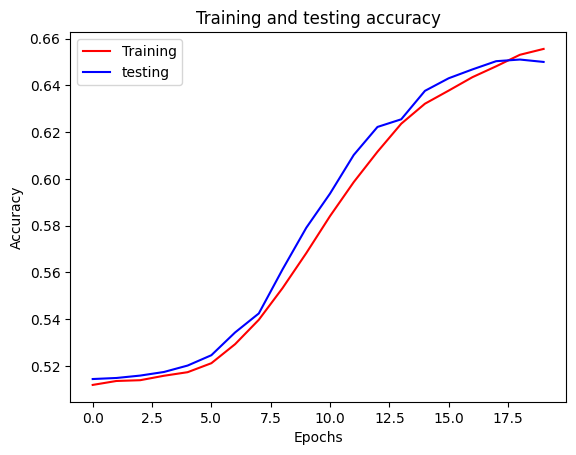

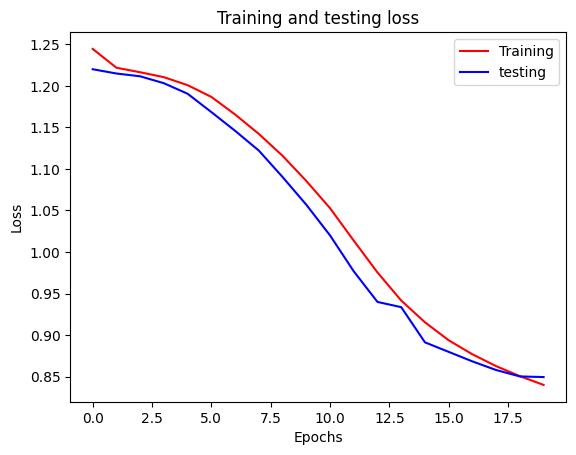

In [31]:
model_name = 'batch_size_64'
in_batch_size = 64
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=in_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_6 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_6 (GRU)                 (None, 64)                24960     
                                                                 
 dense_12 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_6 (Dropout)         (None, 13745)             0         
                                                                 
 dense_13 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

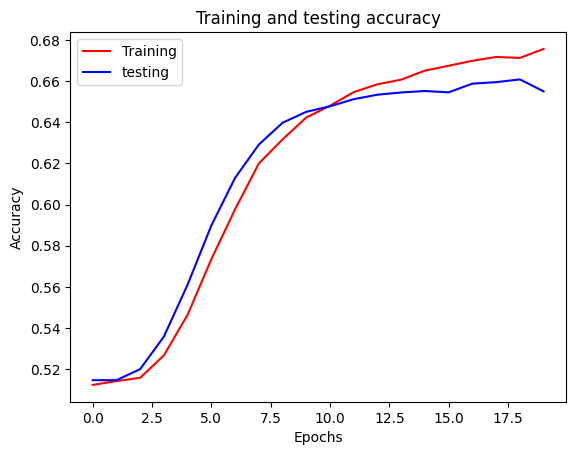

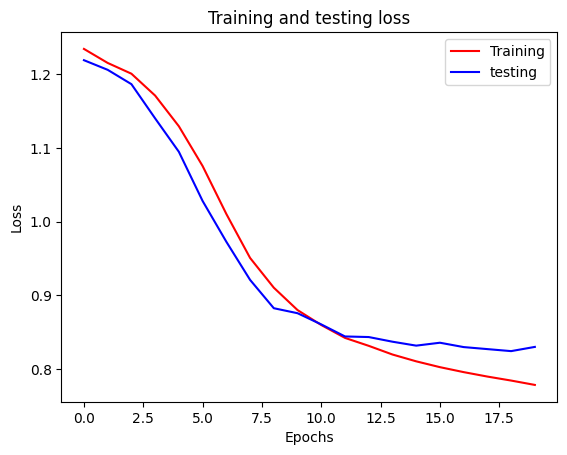

In [32]:
model_name = 'batch_size_32'
in_batch_size = 32
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=in_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 48, 50)            687250    
                                                                 
 lstm_7 (LSTM)               (None, 48, 64)            29440     
                                                                 
 gru_7 (GRU)                 (None, 64)                24960     
                                                                 
 dense_14 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_7 (Dropout)         (None, 13745)             0         
                                                                 
 dense_15 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
No

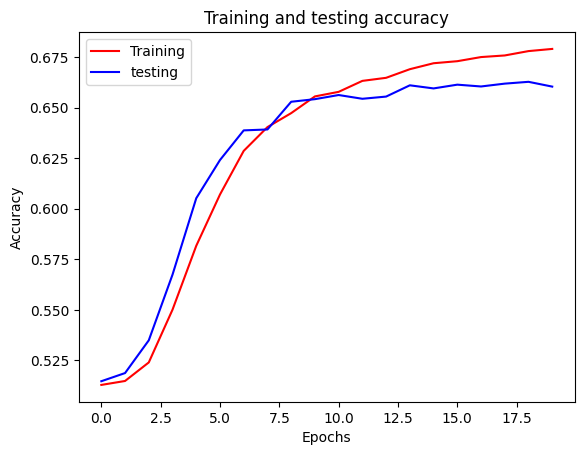

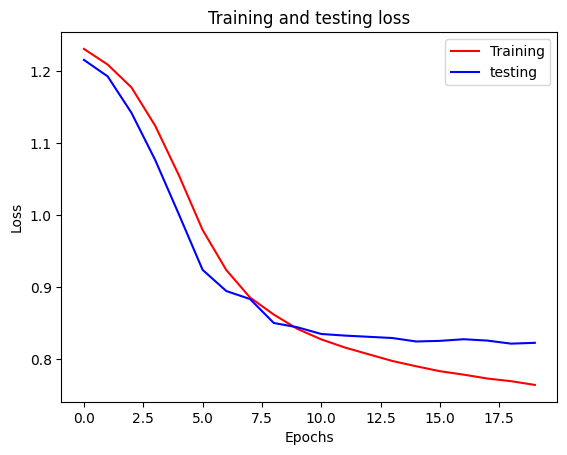

In [33]:
model_name = 'batch_size_24'
in_batch_size = 24
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adagrad',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=in_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

In [37]:
# Use best batch size value
best_batch_size = 24

# Hyperparameter Tuning
## Optimizer

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_10 (LSTM)              (None, 48, 64)            29440     
                                                                 
 gru_10 (GRU)                (None, 64)                24960     
                                                                 
 dense_20 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_10 (Dropout)        (None, 13745)             0         
                                                                 
 dense_21 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
N

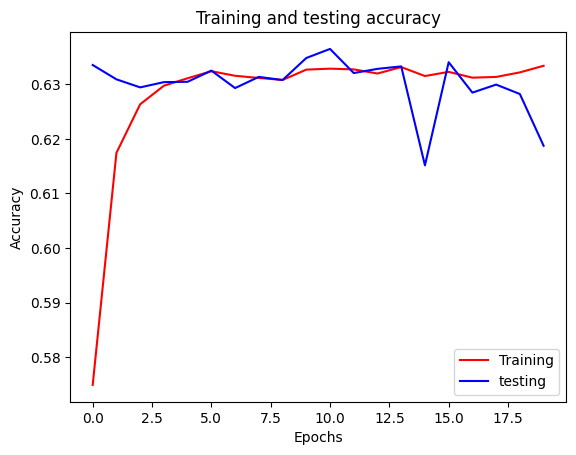

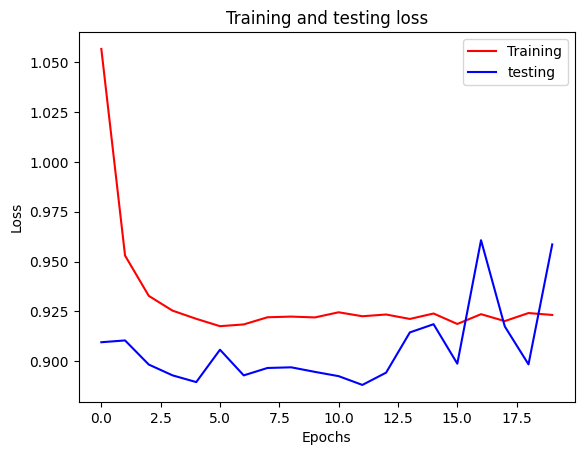

In [38]:
model_name = 'optimizer_adam'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adam',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_11 (LSTM)              (None, 48, 64)            29440     
                                                                 
 gru_11 (GRU)                (None, 64)                24960     
                                                                 
 dense_22 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_11 (Dropout)        (None, 13745)             0         
                                                                 
 dense_23 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
N

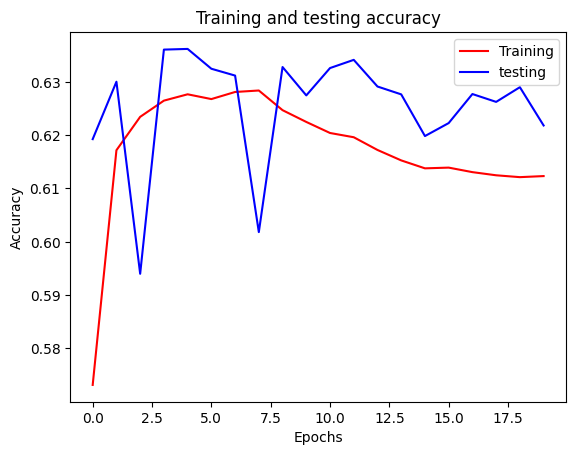

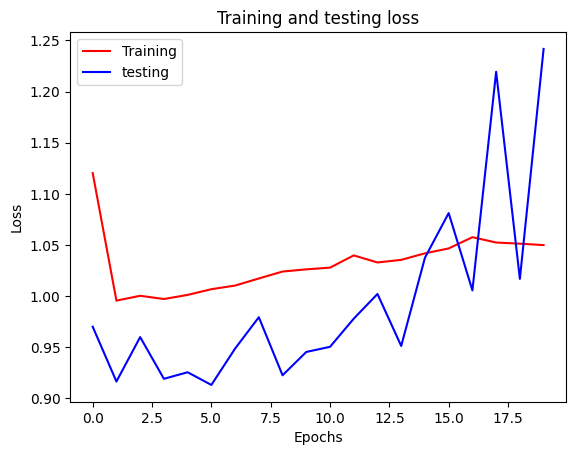

In [39]:
model_name = 'optimizer_rmsprop'
model = create_model(architecture='LSTM-GRU',
                     optimizer='RMSprop',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_12 (LSTM)              (None, 48, 64)            29440     
                                                                 
 gru_12 (GRU)                (None, 64)                24960     
                                                                 
 dense_24 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_12 (Dropout)        (None, 13745)             0         
                                                                 
 dense_25 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
N

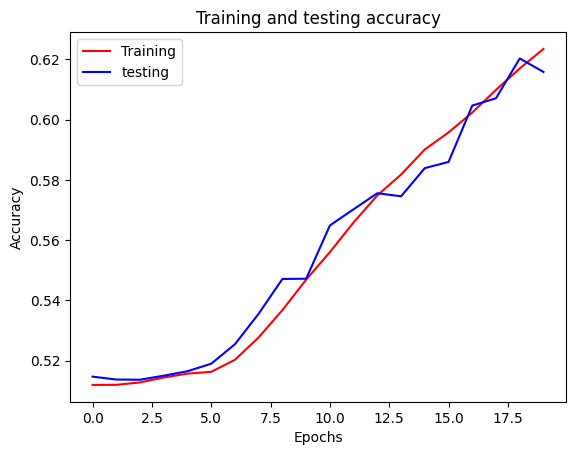

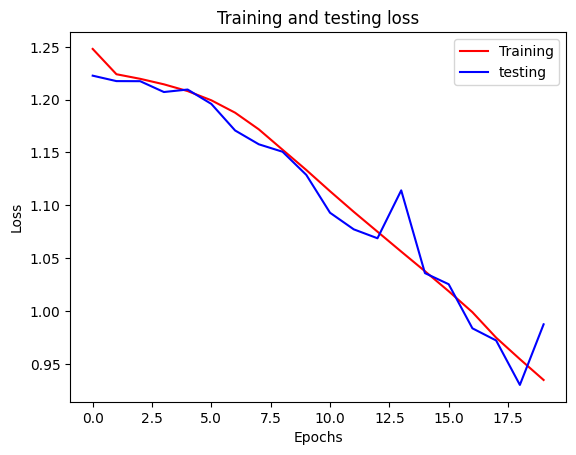

In [40]:
model_name = 'optimizer_sgd'
model = create_model(architecture='LSTM-GRU',
                     optimizer='SGD',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_13 (LSTM)              (None, 48, 64)            29440     
                                                                 
 gru_13 (GRU)                (None, 64)                24960     
                                                                 
 dense_26 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_13 (Dropout)        (None, 13745)             0         
                                                                 
 dense_27 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
N

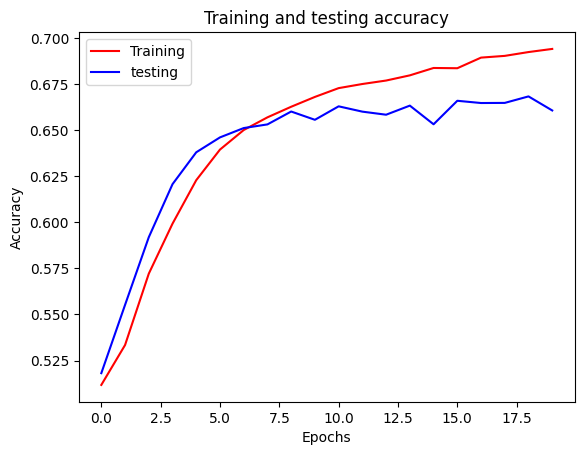

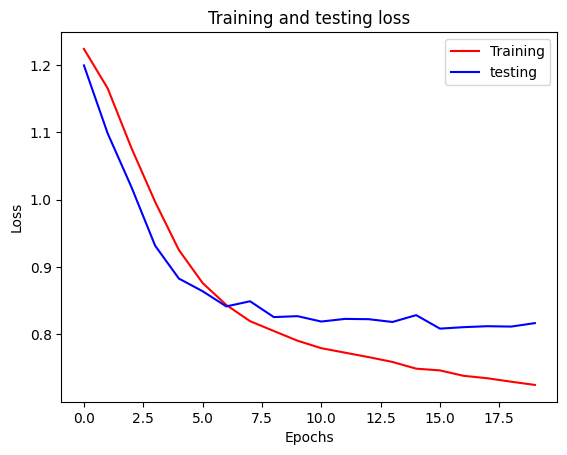

In [41]:
model_name = 'optimizer_momentum'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Momentum',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_14 (LSTM)              (None, 48, 64)            29440     
                                                                 
 gru_14 (GRU)                (None, 64)                24960     
                                                                 
 dense_28 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_14 (Dropout)        (None, 13745)             0         
                                                                 
 dense_29 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,703,805
Trainable params: 1,703,805
N

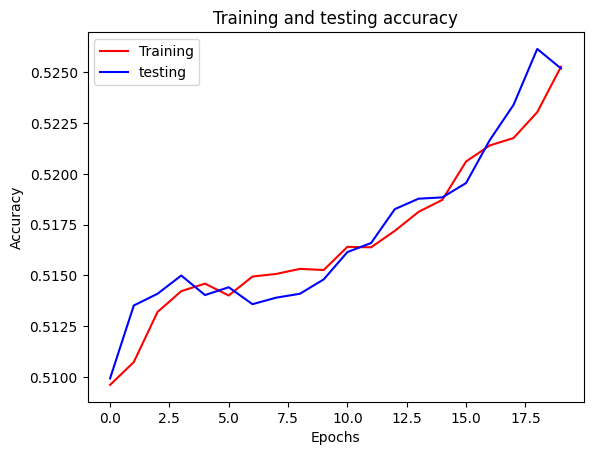

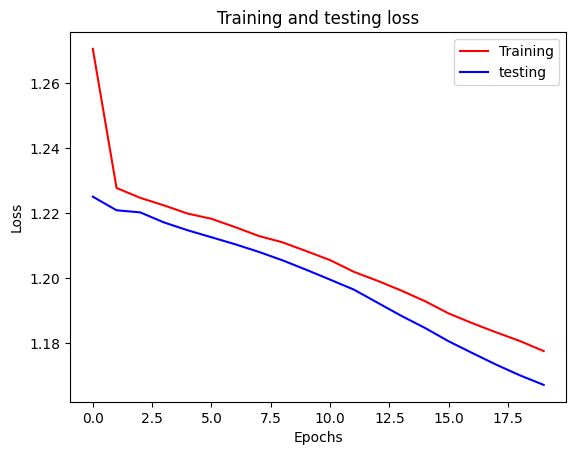

In [42]:
model_name = 'optimizer_adadelta'
model = create_model(architecture='LSTM-GRU',
                     optimizer='Adadelta',
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

In [43]:
# Use best optimizer
best_optimizer = 'Momentum'

# Architecture test 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 48, 50)            687250    
                                                                 
 lstm_15 (LSTM)              (None, 48, 64)            29440     
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dense_30 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_15 (Dropout)        (None, 13745)             0         
                                                                 
 dense_31 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,711,869
Trainable params: 1,711,869
N

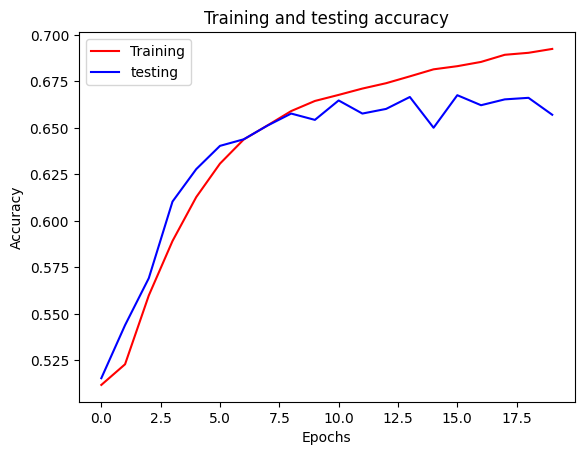

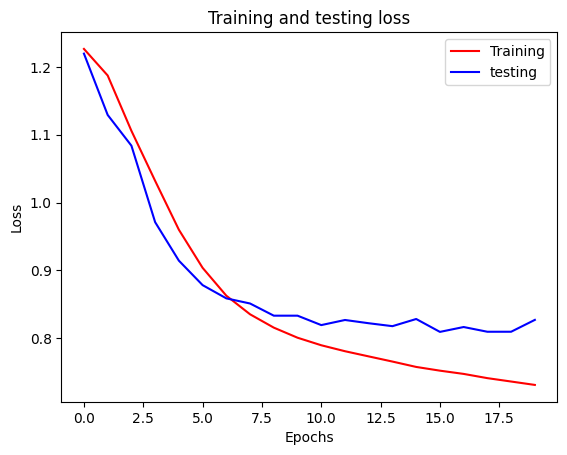

In [44]:
model_name = 'architecture_LSTM'
model = create_model(architecture='LSTM',
                     optimizer=best_optimizer,
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 48, 50)            687250    
                                                                 
 gru_15 (GRU)                (None, 48, 64)            22272     
                                                                 
 gru_16 (GRU)                (None, 64)                24960     
                                                                 
 dense_32 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_16 (Dropout)        (None, 13745)             0         
                                                                 
 dense_33 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,696,637
Trainable params: 1,696,637
N

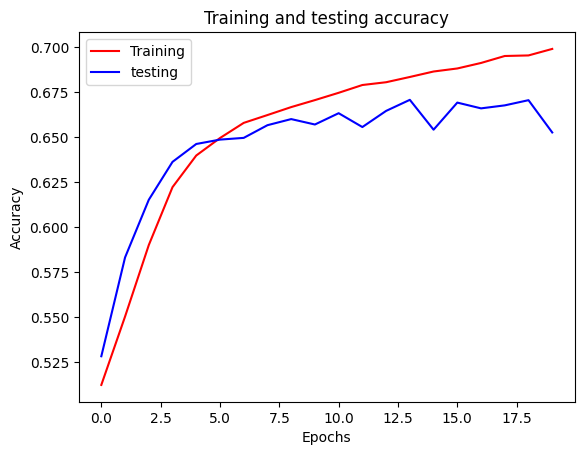

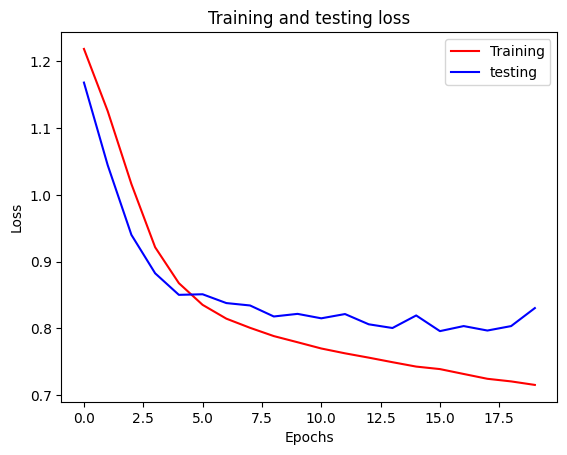

In [45]:
model_name = 'architecture_GRU'
model = create_model(architecture='GRU',
                     optimizer=best_optimizer,
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 48, 50)            687250    
                                                                 
 simple_rnn (SimpleRNN)      (None, 48, 64)            7360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 13745)             893425    
                                                                 
 dropout_17 (Dropout)        (None, 13745)             0         
                                                                 
 dense_35 (Dense)            (None, 5)                 68730     
                                                                 
Total params: 1,665,021
Trainable params: 1,665,021
N

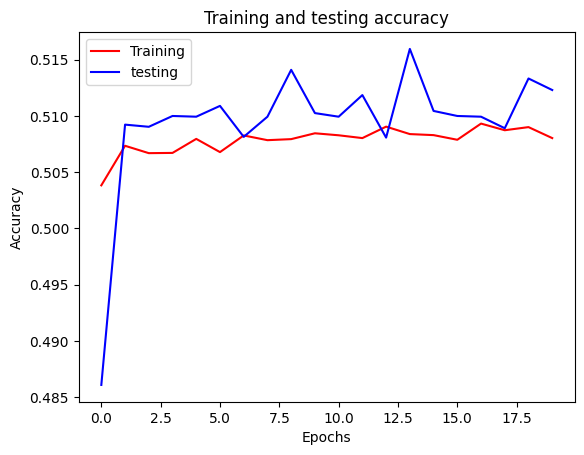

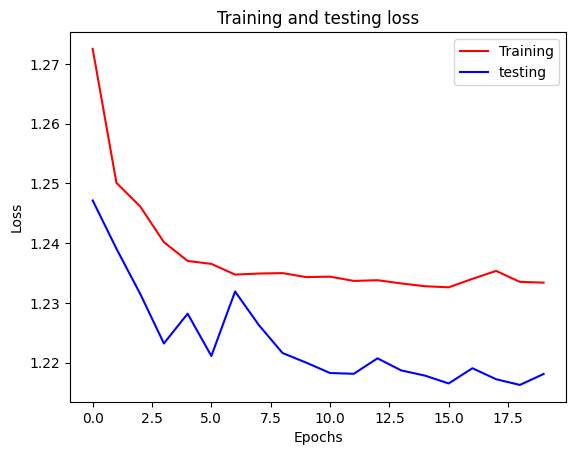

In [46]:
model_name = 'architecture_RNN'
model = create_model(architecture='RNN',
                     optimizer=best_optimizer,
                     lr=best_lr)
# checkpoint callback to save best model during hyper-parameters tuning step
checkpoint = ModelCheckpoint(f"hyperpara_tuning\\{model_name}.keras", monitor='val_accuracy', save_best_only=True, mode='max')
# fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=best_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)
# save history
with open(f"hyperpara_tuning\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# display results
plot_accuracies(history)

# Metryki i wykresy

In [59]:
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import os
import glob
from keras.models import load_model

In [58]:
model = load_model('hyperpara_tuning/optimizer_momentum.keras')

# Przewidywanie etykiet dla danych testowych
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_list = np.argmax(y_val, axis=1)
print(y_pred_classes)
print(y_val_list)

# Obliczanie accuracy
accuracy = accuracy_score(y_val_list, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Obliczanie F1-score
f1 = f1_score(y_val_list, y_pred_classes, average='weighted')  # Można użyć 'micro', 'macro' lub 'weighted'
print(f'F1-score: {f1:.4f}')

488/488 [==============================] - 16s 32ms/step
[1 1 3 ... 1 1 2]
[2 1 3 ... 2 2 2]
Accuracy: 0.6683
F1-score: 0.6573


In [62]:
# stwórz listę modeli
folder_path = 'hyperpara_tuning'
model_files = glob.glob(os.path.join(folder_path, '*.keras'))
# przygotowanie wartości walidacyjnych
y_val_list = np.argmax(y_val, axis=1)
# wczytywanie modeli
for model_file in model_files:
    model = load_model(model_file) 
    # metryki modeli
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Obliczanie accuracy
    accuracy = accuracy_score(y_val_list, y_pred_classes)
    # Obliczanie F1-score
    f1 = f1_score(y_val_list, y_pred_classes, average='weighted')  # Można użyć 'micro', 'macro' lub 'weighted'
    print(f'{model_file}: Accuracy:{accuracy:.4f}, F1-score:{f1:.4f}') 
# metryki modeli

488/488 [==============================] - 16s 32ms/step
hyperpara_tuning\architecture_GRU.keras: Accuracy:0.6708, F1-score:0.6629
488/488 [==============================] - 19s 38ms/step
hyperpara_tuning\architecture_LSTM.keras: Accuracy:0.6676, F1-score:0.6585
488/488 [==============================] - 8s 16ms/step
hyperpara_tuning\architecture_RNN.keras: Accuracy:0.5160, F1-score:0.4011
488/488 [==============================] - 17s 34ms/step
hyperpara_tuning\batch_size_128.keras: Accuracy:0.5936, F1-score:0.5550
488/488 [==============================] - 17s 34ms/step
hyperpara_tuning\batch_size_16.keras: Accuracy:0.6642, F1-score:0.6530
488/488 [==============================] - 17s 34ms/step
hyperpara_tuning\batch_size_24.keras: Accuracy:0.6628, F1-score:0.6511
488/488 [==============================] - 17s 34ms/step
hyperpara_tuning\batch_size_32.keras: Accuracy:0.6609, F1-score:0.6480
488/488 [==============================] - 17s 34ms/step
hyperpara_tuning\batch_size_64.keras: